In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from collections import defaultdict
import timeit

In [2]:
def set_plots_size_params(size):
    # Adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    bigger = size * 1.2
    slightly_bigger = size * 1.1
    plt.rc('font', size=size)                        # controls default text sizes
    plt.rc('axes', titlesize=bigger)                 # fontsize of the axes title
    plt.rc('axes', labelsize=slightly_bigger)        # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)                  # fontsize of the tick labels
    plt.rc('legend', fontsize=size)                  # legend fontsize
    plt.rc('figure', figsize=(0.75*size, size/2))    # size of figure
    return
set_plots_size_params(20)

In [3]:
def these_muts_chance(mutations, fitness_distribution):
    return np.product(np.power(fitness_distribution, mutations))


def get_mutation_probs(mutation_rate, min_freq):
    probs = dict()
    for num_of_muts in range(20):
        prob = poisson.pmf(num_of_muts, mutation_rate)
        if prob <= min_freq:
            break
        probs[num_of_muts] = prob
    return probs


def get_mutations(mutation_rate, fitness_distribution, min_freq, max_mutations=20):
    possible_mutations = []
    for a1 in range(max_mutations+1):
        for a2 in range(max_mutations+1):
            for a3 in range(max_mutations+1):
                perm = (a1,a2,a3)
                if sum(perm)>max_mutations or perm in possible_mutations:
                    continue
                possible_mutations.append(perm)
    possible_mutations = tuple(possible_mutations)
    this_many_muts_chance = get_mutation_probs(mutation_rate, min_freq)
    mutations_prob = dict()
    for mut_tuple in possible_mutations:
        num_of_muts = sum(mut_tuple)
        if num_of_muts in this_many_muts_chance.keys():  
            mut_prob = this_many_muts_chance[num_of_muts] * these_muts_chance(mut_tuple, fitness_distribution)
            if mut_prob > min_freq:
                mutations_prob[mut_tuple] = mut_prob
    return mutations_prob

In [4]:
def simulate_next_passage_comprehensible(fitness_values, genotype_freqs, mutation_probabilities, min_freq):
    # this is slow but comprehensible
    new_freqs = defaultdict(float)
    for genotype, freq in genotype_freqs.items():
        for mutation, mut_freq in mutation_probabilities.items():
            new_genotype = tuple(np.add(genotype, mutation).tolist())
            fitness = np.product(np.power(fitness_values, new_genotype))
            new_freq = freq * mut_freq * fitness
            new_freqs[new_genotype] += new_freq
    new_freqs = pd.Series(new_freqs)
    new_freqs /= sum(new_freqs)
    return new_freqs[new_freqs > min_freq]

In [19]:
def simulate_next_passage_fast(fitness_values, genotype_freqs, mutations, mutations_freqs, min_freq):
    # turn dict into arrays:
    genotypes = np.array(list(genotype_freqs.keys()), dtype=int)
    genotypes_freqs = np.array(list(genotype_freqs.values()), dtype=float)
    # do that numpy magic:
    new_genotypes = genotypes.reshape(-1,1,3) + mutations
    new_freqs = genotypes_freqs.reshape(-1,1,1) * mutations_freqs
    fitness = np.product(np.power(fitness_values, new_genotypes), axis=2)
    new_genotypes = map(tuple, new_genotypes.reshape(-1,3))
    new_freqs = new_freqs.reshape(-1) * fitness.reshape(-1)
    # turn back into dict:
    freqs_dict = defaultdict(float)
    for mut, freq in zip(new_genotypes, new_freqs):
        freqs_dict[mut] += freq
    freqs_sum = sum(freqs_dict.values())
    freqs_dict = {key: val/freqs_sum for key, val in freqs_dict.items()}
    freqs_dict = {key: val for key, val in freqs_dict.items() if val>min_freq}
    return freqs_dict


def model(fitness_distribution, fitness_values, mutation_rate, passages, fast=True, virions_num=10**10):
    passage = dict()
    passage[0] = {(0,0,0) :1}
    min_freq = 1/virions_num
    mutation_probabilities = get_mutations(mutation_rate, fitness_distribution, min_freq)
    mutations = np.array(list(mutation_probabilities.keys()), dtype=int).reshape(1,-1,3)
    mutations_freqs = np.array(list(mutation_probabilities.values()), dtype=float).reshape(1,-1,1)
    for i in range(passages):
        if fast:
            passage[i+1] = simulate_next_passage_fast(fitness_values, passage[i], mutations, mutations_freqs,
                                                      min_freq)
        else:
            passage[i+1] = simulate_next_passage_comprehensible(fitness_values, passage[i], 
                                                                mutation_probabilities, min_freq)
    return pd.DataFrame(passage)

In [6]:
fitness_distribution = np.array([0.5, 0.49, 0.01])
fitness_values = np.array([0.2, 1, 1.5])
mutation_rate = 0.8
passages = 10

data = model(fitness_distribution, fitness_values, mutation_rate, passages)
data_comprehensible = model(fitness_distribution, fitness_values, mutation_rate, passages, fast=False)

## Sanity check - data created via the comprehensible methods should be identical to the data created with the fast method:

In [7]:
abs(data - data_comprehensible).max().max()

0.0

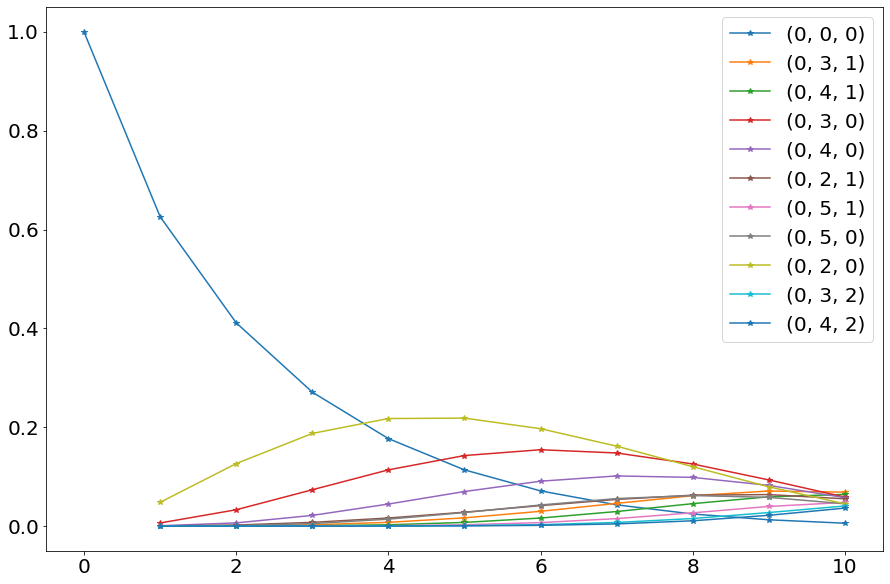

In [8]:
rising_muts = data.sort_values(by=data.columns.max(), ascending=False).head(10).index
plt.plot(data.loc[(0,0,0), 0:], label=(0,0,0), marker='*')
for mut in rising_muts:
    plt.plot(data.loc[mut, 0:], label=mut, marker='*')
plt.legend(bbox_to_anchor=(1,1))

In [9]:
%timeit model(fitness_distribution, fitness_values, mutation_rate, passages, fast=False)

3.82 s ± 75.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit model(fitness_distribution, fitness_values, mutation_rate, passages, fast=True)

472 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## get_mutations is not optimised.. but how much do we have to gain from vectorizing it?

In [12]:
%timeit get_mutations(mutation_rate, fitness_distribution, 1/(10**10))

39 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
